# Imports

In [27]:
import base64
from functools import partial
from io import BytesIO
import json
import os
from pathlib import Path
import pickle

import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

import numpy as np
import pandas as pd

from flax import serialization
from omegaconf import OmegaConf
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import mediapy
import plotly.graph_objects as go
import plotly.express as px

from IPython.display import display, HTML

from qdax.core.containers.unstructured_repertoire import UnstructuredRepertoire

from analysis.visualize_aurora import plot_aurora_repertoire
from common import get_metric
from lenia.lenia import ConfigLenia, Lenia
from cl_vae import VAE

## Directories

In [37]:
CL_run_dir = Path("output/aurora_cl/neg_angle_var/2024-08-29_035754_902295")

## Standard Functions

#### Functions to calculate novelty in the descriptor space

In [29]:
def calculate_novelty(descriptors, d, k=800):
    """ Calculating mean, std, min and max novelty of descriptors in a repertoire"""
    novelties = []

    if d == 2:
        # Calculate novelty for 2D descriptors
        # For 2D descriptors, we might use Euclidean distance between descriptors
        
        # Compute pairwise distances between descriptors
        distances = np.linalg.norm(descriptors[:, np.newaxis, :] - descriptors[np.newaxis, :, :], axis=-1)
        
        # Sort distances for each descriptor
        sorted_distances = np.sort(distances, axis=1)
        
        # Take the mean of the k smallest distances for each descriptor
        novelty = np.mean(sorted_distances[:, 1:k+1], axis=1)
        
        # Store novelty values
        novelties.extend(novelty)
        
    elif d == 3:
        # Calculate novelty for 3D descriptors
        # For 3D descriptors, we might use a similar approach or a different distance metric
        
        # Compute pairwise distances between descriptors
        distances = np.linalg.norm(descriptors[:, np.newaxis, :] - descriptors[np.newaxis, :, :], axis=-1)
        
        # Sort distances for each descriptor
        sorted_distances = np.sort(distances, axis=1)
        
        # Take the mean of the k smallest distances for each descriptor
        novelty = np.mean(sorted_distances[:, 1:k+1], axis=1)
        
        # Store novelty values
        novelties.extend(novelty)

    # Calculate mean, std, min, and max of novelties
    mean_novelty = np.mean(novelties)
    std_novelty = np.std(novelties)
    min_novelty = np.min(novelties)
    max_novelty = np.max(novelties)

    return mean_novelty, std_novelty, min_novelty, max_novelty

def calculate_novelties(descriptors, d, k=800):
    """ Calculate novelty scores for all descriptors """
    if d not in [2, 3]:
        raise ValueError("d must be either 2 or 3")

    # Compute pairwise distances between descriptors
    distances = np.linalg.norm(descriptors[:, np.newaxis, :] - descriptors[np.newaxis, :, :], axis=-1)
    
    # Sort distances for each descriptor
    sorted_distances = np.sort(distances, axis=1)
    
    # Take the mean of the k smallest distances for each descriptor
    novelties = np.mean(sorted_distances[:, 1:k+1], axis=1)
    
    return novelties

#### Interactive t-SNE plot

In [30]:
def process_image(img):
    np_img = np.array(img)
    if np_img.max() <= 1.0:
        np_img = (np_img * 255).astype(np.uint8)
    else:
        np_img = np_img.astype(np.uint8)
    return np_img

def image_to_base64(img):
    buffered = BytesIO()
    Image.fromarray(img).save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

def create_tsne_plot(descriptors, images, dir, output_file=f'tsne_plot_with_images.html'):
    output_file = os.path.join(dir, output_file)
    # Process images
    processed_images = [process_image(img) for img in images]
    base64_images = [image_to_base64(img) for img in processed_images]
    
    # Perform t-SNE
    tsne = TSNE(n_components=3, perplexity=5.0, random_state=42)
    descriptors_3d = tsne.fit_transform(np.array(descriptors))
    
    # Prepare data for Plotly
    trace_data = {
        'x': descriptors_3d[:, 0].tolist(),
        'y': descriptors_3d[:, 1].tolist(),
        'z': descriptors_3d[:, 2].tolist(),
        'mode': 'markers',
        'type': 'scatter3d',
        'marker': {
            'size': 5,
            'color': descriptors_3d[:, 2].tolist(),
            'colorscale': 'Viridis',
            'opacity': 0.8
        }
    }

    # Create HTML content
    html_content = f"""
    <html>
    <head>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    </head>
    <body>
        <div id="plot" style="width:800px;height:600px;float:left;"></div>
        <div id="image-container" style="float:left;margin-left:20px;">
            <img id="selected-image" width="300" height="300" />
        </div>
        <script>
            var data = [{json.dumps(trace_data)}];
            var layout = {{
                scene: {{
                    xaxis: {{title: 't-SNE 1'}},
                    yaxis: {{title: 't-SNE 2'}},
                    zaxis: {{title: 't-SNE 3'}}
                }},
                margin: {{l: 0, r: 0, b: 0, t: 0}}
            }};
            Plotly.newPlot('plot', data, layout);

            var base64Images = {json.dumps(base64_images)};
            document.getElementById('plot').on('plotly_click', function(data) {{
                var point = data.points[0];
                var imgSrc = 'data:image/png;base64,' + base64Images[point.pointNumber];
                document.getElementById('selected-image').src = imgSrc;
            }});
        </script>
    </body>
    </html>
    """

    # Save to file
    with open(output_file, 'w') as f:
        f.write(html_content)
    
    print(f"Plot saved as '{output_file}'")
    
    display(HTML(html_content))
    
def create_tsne_plot_2d(descriptors, images, dir, output_file='tsne_plot_2d_with_images.html'):
    output_file = os.path.join(dir, output_file)
    # Process images
    processed_images = [process_image(img) for img in images]
    base64_images = [image_to_base64(img) for img in processed_images]
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=5.0, random_state=42)
    descriptors_2d = tsne.fit_transform(np.array(descriptors))
    
    # Prepare data for Plotly
    trace_data = {
        'x': descriptors_2d[:, 0].tolist(),
        'y': descriptors_2d[:, 1].tolist(),
        'mode': 'markers',
        'type': 'scatter',
        'marker': {
            'size': 8,
            'color': 'blue',  # Single color for all points
            'opacity': 0.7
        }
    }

    # Create HTML content
    html_content = f"""
    <html>
    <head>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    </head>
    <body>
        <div id="plot" style="width:800px;height:600px;float:left;"></div>
        <div id="image-container" style="float:left;margin-left:20px;">
            <img id="selected-image" width="300" height="300" />
            <p id="point-info"></p>
        </div>
        <script>
            var data = [{json.dumps(trace_data)}];
            var layout = {{
                xaxis: {{title: 't-SNE 1'}},
                yaxis: {{title: 't-SNE 2'}},
                margin: {{l: 50, r: 50, b: 50, t: 50}},
                title: '2D t-SNE Plot of Descriptors'
            }};
            Plotly.newPlot('plot', data, layout);

            var base64Images = {json.dumps(base64_images)};
            document.getElementById('plot').on('plotly_click', function(data) {{
                var point = data.points[0];
                var imgSrc = 'data:image/png;base64,' + base64Images[point.pointNumber];
                document.getElementById('selected-image').src = imgSrc;
                document.getElementById('point-info').textContent = 'Index: ' + point.pointNumber;
            }});
        </script>
    </body>
    </html>
    """

    # Save to file
    with open(output_file, 'w') as f:
        f.write(html_content)
    
    print(f"Plot saved as '{output_file}'")
    
    display(HTML(html_content))

#### Functions to initialise Lenia and QD functions

In [31]:
def get_fitness(accum):
	fitness = get_metric(accum, config.qd.fitness, config.qd.n_keep)
	assert fitness.size == 1
	fitness = jnp.squeeze(fitness)
	failed = jnp.logical_or(accum.stats.is_empty.any(), accum.stats.is_full.any())
	failed = jnp.logical_or(failed, accum.stats.is_spread.any())
	fitness = jnp.where(failed, -jnp.inf, fitness)
	return fitness

def evaluate(genotype):
	carry = lenia.express_genotype(init_carry, genotype)
	carry, accum = jax.lax.scan(lenia_step, init=carry, xs=jnp.arange(lenia._config.n_step))
	return accum

def evaluate_small(genotype):
	carry = lenia.express_genotype(init_carry, genotype)
	carry, accum = jax.lax.scan(lenia_step_small, init=carry, xs=jnp.arange(lenia._config.n_step))
	return accum

def evaluate_medium(genotype):
	carry = lenia.express_genotype(init_carry, genotype)
	carry, accum = jax.lax.scan(lenia_step_medium, init=carry, xs=jnp.arange(lenia._config.n_step))
	return accum

def evaluate_large(genotype):
	carry = lenia.express_genotype(init_carry, genotype)
	carry, accum = jax.lax.scan(lenia_step_large, init=carry, xs=jnp.arange(lenia._config.n_step))
	return accum

In [32]:
def initialize_lenia_simulation(run_dir):
    # Get config
    config = OmegaConf.load(run_dir / ".hydra" / "config.yaml")

    # Init a random key
    key = jax.random.PRNGKey(config.seed)

    # Lenia configuration
    config_lenia = ConfigLenia(
        # Init pattern
        pattern_id=config.pattern_id,

        # Simulation
        world_size=config.world_size,
        world_scale=config.world_scale,
        n_step=config.n_step,

        # Genotype
        n_params_size=config.n_params_size,
        n_cells_size=config.n_cells_size,
    )
    lenia = Lenia(config_lenia)

    # Lenia steps
    lenia_step = partial(lenia.step, phenotype_size=config_lenia.world_size, center_phenotype=False, record_phenotype=True, adaptive_phenotype=False, switch=False)
    lenia_step_small = partial(lenia.step, phenotype_size=config.phenotype_size, center_phenotype=True, record_phenotype=True, adaptive_phenotype=False, switch=False)
    lenia_step_medium = partial(lenia.step, phenotype_size=64, center_phenotype=True, record_phenotype=True, adaptive_phenotype=False, switch=False)
    lenia_step_large = partial(lenia.step, phenotype_size=config.world_size, center_phenotype=True, record_phenotype=True, adaptive_phenotype=False, switch=False)

    # Load pattern
    init_carry, init_genotype, other_asset = lenia.load_pattern(lenia.pattern)

    return {
        "config": config,
        "key": key,
        "lenia": lenia,
        "lenia_step": lenia_step,
        "lenia_step_small": lenia_step_small,
        "lenia_step_medium": lenia_step_medium,
        "lenia_step_large": lenia_step_large,
        "init_carry": init_carry,
        "init_genotype": init_genotype,
        "other_asset": other_asset,
    }

## Contrastive Learning AURORA

#### Initialise Lenia and QD

In [38]:
run_dir = CL_run_dir

# Call the function
simulation_data = initialize_lenia_simulation(run_dir)

# Access the returned dictionary's values by their keys
config = simulation_data["config"]
key = simulation_data["key"]
lenia = simulation_data["lenia"]
lenia_step = simulation_data["lenia_step"]
lenia_step_small = simulation_data["lenia_step_small"]
lenia_step_medium = simulation_data["lenia_step_medium"]
lenia_step_large = simulation_data["lenia_step_large"]
init_carry = simulation_data["init_carry"]
init_genotype = simulation_data["init_genotype"]
other_asset = simulation_data["other_asset"]

In [39]:
_, reconstruction_fn = ravel_pytree(init_genotype)
repertoire = UnstructuredRepertoire.load(reconstruction_fn=reconstruction_fn, path=str(run_dir) + "/repertoire/")

repertoire = repertoire.replace(observations=jnp.zeros((repertoire.size)))

In [40]:
# Instantiate AURORA
key, subkey_1, subkey_2 = jax.random.split(key, 3)
phenotype_fake = jnp.zeros((config.phenotype_size, config.phenotype_size, lenia.n_channel))
vae = VAE(img_shape=phenotype_fake.shape, latent_size=config.qd.hidden_size, features=config.qd.features, group_cnn=True)
params = vae.init(subkey_1, phenotype_fake, subkey_2)

with open(run_dir / "params.pickle", "rb") as params_file:
	state_dict = pickle.load(params_file)
params = serialization.from_state_dict(params, state_dict)

2024-09-03 10:53:49,035 - INFO - RotationInvariantEncoder input shape: (32, 32, 3)
2024-09-03 10:53:49,036 - INFO - RotationEquivariantConv input shape: (32, 32, 3)
2024-09-03 10:53:49,037 - INFO - Padding configuration: ((1, 1), (1, 1), (0, 0))
2024-09-03 10:53:49,042 - INFO - Shape after 0 degree rotation and conv: (17, 17, 256)
2024-09-03 10:53:49,049 - INFO - Shape after 90 degree rotation and conv: (17, 17, 256)
2024-09-03 10:53:49,055 - INFO - Shape after 180 degree rotation and conv: (17, 17, 256)
2024-09-03 10:53:49,063 - INFO - Shape after 270 degree rotation and conv: (17, 17, 256)
2024-09-03 10:53:49,064 - INFO - RotationEquivariantConv output shape: (17, 17, 256)
2024-09-03 10:53:49,066 - INFO - Shape after first RotationEquivariantConv: (17, 17, 256)
2024-09-03 10:53:49,067 - INFO - RotationEquivariantConv input shape: (17, 17, 256)
2024-09-03 10:53:49,068 - INFO - Padding configuration: ((1, 1), (1, 1), (0, 0))
2024-09-03 10:53:49,074 - INFO - Shape after 0 degree rotatio

In [ ]:
# for every descriptor in the repertoire, find how many are NaN
nan_count = jnp.isnan(repertoire.descriptors).sum()
nan_count

#### t-SNE visualisations and analysis

In [ ]:
tsne = TSNE(n_components=3, perplexity=5., max_iter=1000)
descriptors_3d = tsne.fit_transform(repertoire.descriptors)

mean_novelty, std_novelty, min_novelty, max_novelty = calculate_novelty(descriptors_3d, 3, k=5)
print(f"Mean novelty: {mean_novelty:.2f}, std novelty: {std_novelty:.2f}, min novelty: {min_novelty:.2f}, max novelty: {max_novelty:.2f}")

fig, axes = plot_aurora_repertoire(config, repertoire, descriptors_3d)
plt.show()
plt.close()

In [ ]:
tsne_2d = TSNE(n_components=2, perplexity=12., max_iter=1000, random_state=42)
# if any repertoire.descriptors is nan, replace it with 0

descriptors_2d = tsne_2d.fit_transform(repertoire.descriptors)
mean_novelty_2d, std_novelty_2d, min_novelty_2d, max_novelty_2d = calculate_novelty(descriptors_2d, 2, k=5)
print(f"2D Mean novelty: {mean_novelty_2d:.2f}, 2D std novelty: {std_novelty_2d:.2f}, 2D min novelty: {min_novelty_2d:.2f}, 2D max novelty: {max_novelty_2d:.2f}")

#plot the TSNE plots without using the plot_aurora_repertoire function, overlaying the two runs
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(descriptors_2d[:, 0], descriptors_2d[:, 1], c='b', label='Run 1')
plt.legend()
plt.show()

# save the plot data, specifically the descriptors_2d x and y values to a csv
df = pd.DataFrame(descriptors_2d, columns=['x', 'y'])
df.to_csv(run_dir / 'tsne_2d.csv', index=False)
print(f"TSNE 2D data saved as '{run_dir / 'tsne_2d.csv'}'")


In [ ]:
# Interactive t-SNE plot
accum_small = jax.vmap(evaluate_small)(repertoire.genotypes)
images = accum_small.phenotype[:, -1]  # Extract the last image for each sample

# Create t-SNE plot and save it to a file
create_tsne_plot(repertoire.descriptors, images, run_dir)

In [ ]:
# Interactive t-SNE plot
accum_small = jax.vmap(evaluate_small)(repertoire.genotypes)
images = accum_small.phenotype[:, -1]  # Extract the last image for each sample

# Create t-SNE plot and save it to a file
create_tsne_plot_2d(repertoire.descriptors, images, run_dir)

#### Highest Fitness, Novelty and Random solitons

##### Fitness

In [ ]:
# Select genotypes
genotype_start = 0
indices = jnp.argsort(repertoire.fitnesses)[-1-genotype_start:-1-genotype_start-10:-1]
genotypes = repertoire.genotypes[indices]

# Evaluate
accum = jax.vmap(evaluate)(genotypes)
accum_small = jax.vmap(evaluate_small)(genotypes)

# VAE
key, subkey_1, subkey_2 = jax.random.split(key, 3)
latent = vae.apply(params, accum_small.phenotype, subkey_1, method=vae.encode)

# Display
titles = [f"{index}" for index in indices]
html = mediapy.show_videos(accum.phenotype, titles=titles, width=128, height=128, fps=50, return_html=True)
html += mediapy.show_images(accum_small.phenotype[:, -1], width=128, height=128, return_html=True)

display(HTML(html))

##### Random

In [ ]:
# Select genotypes
num_genotypes = 10
key, subkey = jax.random.split(key)
valid = repertoire.fitnesses != -jnp.inf
indices = jax.random.choice(subkey, jnp.arange(config.qd.repertoire_size), shape=(num_genotypes,), replace=False, p=valid)
genotypes = repertoire.genotypes[indices]

# Evaluate
#accum = jax.vmap(evaluate)(genotypes)
#accum_small = jax.vmap(evaluate_small)(genotypes)
accum_medium = jax.vmap(evaluate_medium)(genotypes)

# VAE
key, subkey_1, subkey_2 = jax.random.split(key, 3)
#latent = vae.apply(params, accum_small.phenotype, subkey_1, method=vae.encode)

# Display
titles = [f"{index}" for index in indices]
#html = mediapy.show_videos(accum.phenotype, titles=titles, width=128, height=128, fps=50, return_html=True)
#html += mediapy.show_images(accum_small.phenotype[:, -1], width=128, height=128, return_html=True)
html = mediapy.show_images(accum_medium.phenotype[:, -1], width=128, height=128, return_html=True)

display(HTML(html))

##### Novelty

In [ ]:
tsne = TSNE(n_components=3, perplexity=5., max_iter=1000)
descriptors_3d = tsne.fit_transform(repertoire.descriptors)

#Calculate novelties
novelties = calculate_novelties(descriptors_3d, d=3)  # Adjust d based on your descriptor dimensionality

# Select genotypes based on novelty
genotype_start = 0
indices = jnp.argsort(novelties)[-1-genotype_start:-1-genotype_start-10:-1]
# Select genotypes based on novelty - least novel ones
indices = jnp.argsort(novelties)[genotype_start:genotype_start+10]
genotypes = repertoire.genotypes[indices]

# Evaluate
accum = jax.vmap(evaluate)(genotypes)
accum_small = jax.vmap(evaluate_small)(genotypes)

# VAE
key, subkey_1, subkey_2 = jax.random.split(key, 3)
latent = vae.apply(params, accum_small.phenotype, subkey_1, method=vae.encode)

# Display
titles = [f"Novelty: {novelties[index]:.4f}" for index in indices]
html = mediapy.show_videos(accum.phenotype, titles=titles, width=128, height=128, fps=50, return_html=True)
html += mediapy.show_images(accum_small.phenotype[:, -1], width=128, height=128, return_html=True)

display(HTML(html))

#### Save the html of all the solitons to a file

In [ ]:

num_genotypes = 70 #len(repertoire.genotypes)
batch_size = 10  # Process genotypes in batches of 10

# Select random genotypes
valid_indices = jnp.where(repertoire.fitnesses != -jnp.inf)[0]
random_indices = jax.random.choice(key, valid_indices, shape=(num_genotypes,), replace=False)
selected_genotypes = repertoire.genotypes[random_indices]

# Generate HTML content in batches
html = ""
for i in range(0, num_genotypes, batch_size):
    batch_genotypes = selected_genotypes[i:i+batch_size]
    batch_indices = random_indices[i:i+batch_size]

    # Evaluate batch genotypes
    batch_accum = jax.vmap(evaluate)(batch_genotypes)

    # Generate HTML for the batch
    titles = [f"Genotype {index}" for index in batch_indices]
    batch_html = mediapy.show_videos(batch_accum.phenotype, titles=titles, width=128, height=128, fps=50, return_html=True)
    html += batch_html

# Save HTML content to a file
output_file = run_dir / "selected_genotypes.html"
with open(output_file, "w") as file:
    file.write(html)

print(f"HTML file saved as: {output_file}")
display(HTML(html))

# Save images to file

HTML file saved as: output/aurora_cl/neg_angle_var/2024-08-29_035754_902295/images.html


Genotype 110,Genotype 109,Genotype 58,Genotype 8,Genotype 104,Genotype 98,Genotype 67,Genotype 135,Genotype 128,Genotype 187
Genotype 76,Genotype 248,Genotype 55,Genotype 16,Genotype 168,Genotype 126,Genotype 32,Genotype 41,Genotype 13,Genotype 46
Genotype 127,Genotype 175,Genotype 143,Genotype 129,Genotype 56,Genotype 29,Genotype 222,Genotype 22,Genotype 211,Genotype 31
Genotype 15,Genotype 90,Genotype 233,Genotype 151,Genotype 84,Genotype 225,Genotype 59,Genotype 184,Genotype 198,Genotype 64
Genotype 40,Genotype 191,Genotype 255,Genotype 243,Genotype 201,Genotype 202,Genotype 178,Genotype 182,Genotype 123,Genotype 28
Genotype 103,Genotype 179,Genotype 142,Genotype 112,Genotype 75,Genotype 38,Genotype 101,Genotype 170,Genotype 188,Genotype 50
Genotype 97,Genotype 54,Genotype 39,Genotype 35,Genotype 164,Genotype 124,Genotype 57,Genotype 144,Genotype 119,Genotype 238
Genotype 117,Genotype 252,Genotype 208,Genotype 253,Genotype 3,Genotype 88,Genotype 250,Genotype 183,Genotype 73,Genotype 156
Genotype 12,Genotype 4,Genotype 93,Genotype 169,Genotype 140,Genotype 247,Genotype 229,Genotype 152,Genotype 234,Genotype 196
Genotype 193,Genotype 52,Genotype 81,Genotype 176,Genotype 71,Genotype 100,Genotype 220,Genotype 205,Genotype 65,Genotype 195
Genotype 66,Genotype 2,Genotype 113,Genotype 217,Genotype 148,Genotype 236,Genotype 245,Genotype 92,Genotype 216,Genotype 105

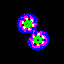
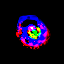
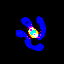
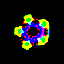
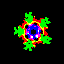
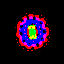
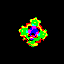
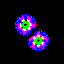
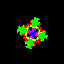
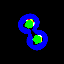
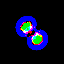
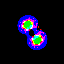
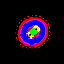
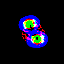
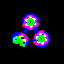
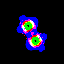
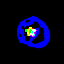
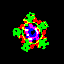
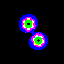
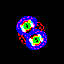
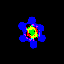
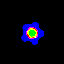
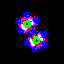
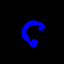
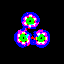
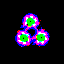
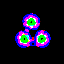
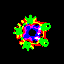
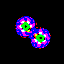
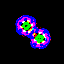
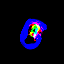
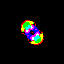
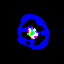
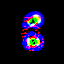
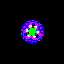
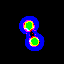
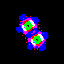
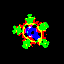
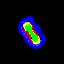
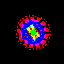
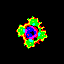
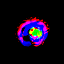
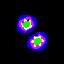
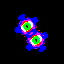
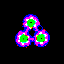
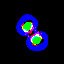
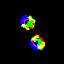
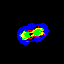
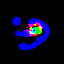
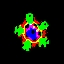
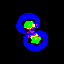
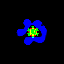
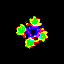
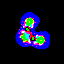
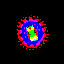
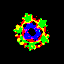
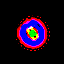
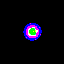
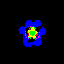
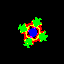
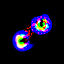
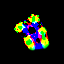
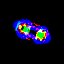
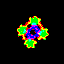
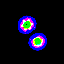
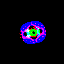
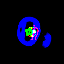
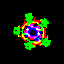
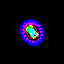
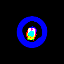
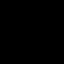
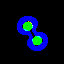
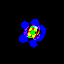
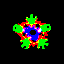
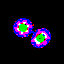
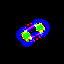
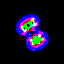
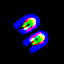
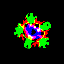
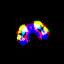
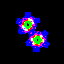
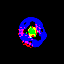
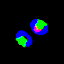
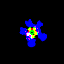
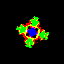
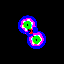
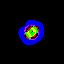
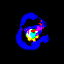
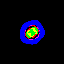
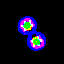
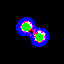
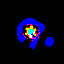
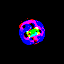
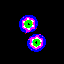
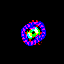
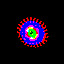
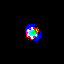
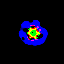
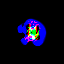
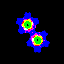
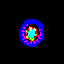
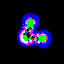
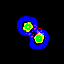
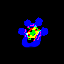
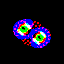
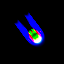
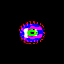
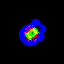
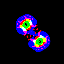
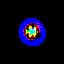
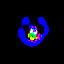
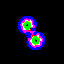
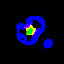
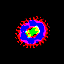
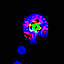
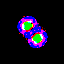
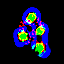
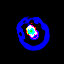
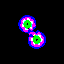
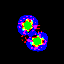
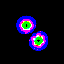
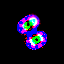
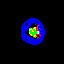
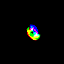
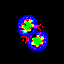
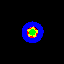
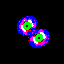
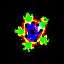
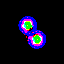
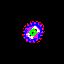
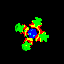
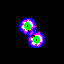
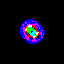
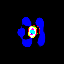
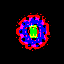
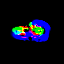
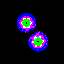
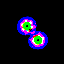
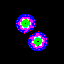
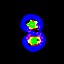
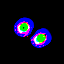
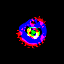
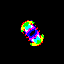
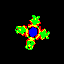
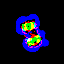
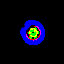
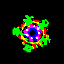
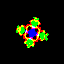
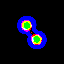
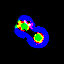
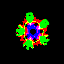
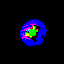
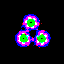
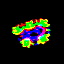
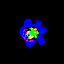
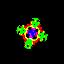
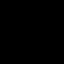
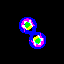
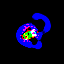
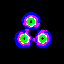
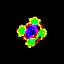
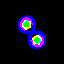
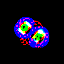
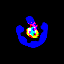
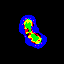
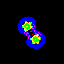
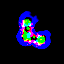
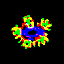
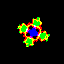
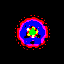
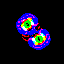
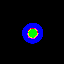
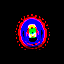
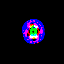
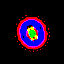
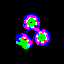
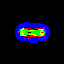
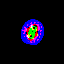
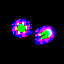
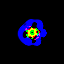
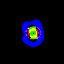
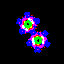
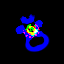
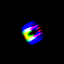
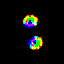
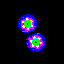
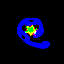
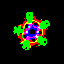
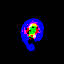
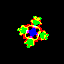
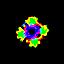
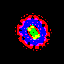
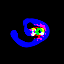
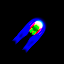
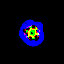
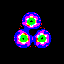
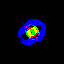
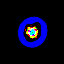
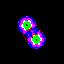
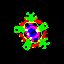
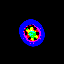
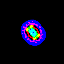
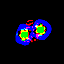
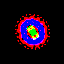
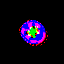
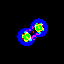
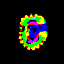
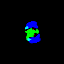
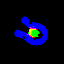
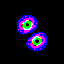
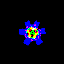
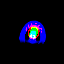
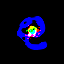
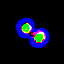
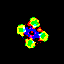
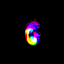
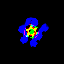
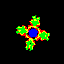
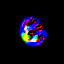
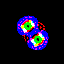
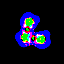
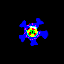
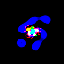
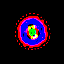
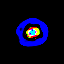
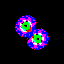
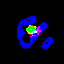
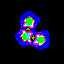
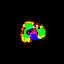
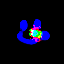
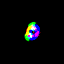
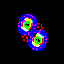
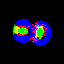
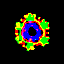
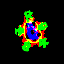
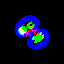
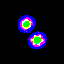
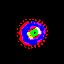
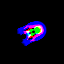
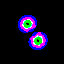
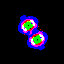
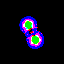
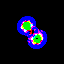
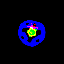
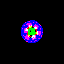
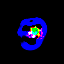
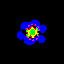
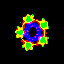
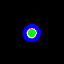
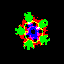
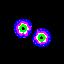
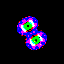
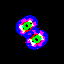
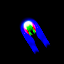
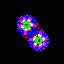
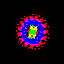

In [41]:
num_genotypes = len(repertoire.genotypes)
batch_size = 10  # Process genotypes in batches of 10
key += 1
# Select random genotypes
valid_indices = jnp.where(repertoire.fitnesses != -jnp.inf)[0]
random_indices = jax.random.choice(key, valid_indices, shape=(num_genotypes,), replace=False)
selected_genotypes = repertoire.genotypes[random_indices]

# Generate HTML content in batches
html = ""
for i in range(0, num_genotypes, batch_size):
    batch_genotypes = selected_genotypes[i:i+batch_size]
    batch_indices = random_indices[i:i+batch_size]

    # Evaluate batch genotypes
    batch_accum = jax.vmap(evaluate_medium)(batch_genotypes)

    # Generate HTML for the batch
    titles = [f"Genotype {index}" for index in batch_indices]
    batch_html = mediapy.show_images(batch_accum.phenotype[:, -1], titles=titles, width=128, height=128, return_html=True)
    html += batch_html

# Save HTML content to a file
output_file = run_dir / "images.html"
with open(output_file, "w") as file:
    file.write(html)

print(f"HTML file saved as: {output_file}")
display(HTML(html))

#### Diversity Heatmap in Descriptor Space


In [ ]:


def descriptor_heatmap(repertoire, config, run_dir):
    # Get descriptors
    descriptors = np.array(repertoire.descriptors)

    # Perform PCA
    pca = PCA(n_components=2)
    descriptors_pca = pca.fit_transform(descriptors)

    # Create a DataFrame
    df = pd.DataFrame(descriptors_pca, columns=["PC1", "PC2"])
    df["fitness"] = repertoire.fitnesses

    # Calculate explained variance ratio
    explained_var_ratio = pca.explained_variance_ratio_
    
    # Create the plot
    fig = px.scatter(
        df,
        x="PC1",
        y="PC2",
        color="fitness",
        color_continuous_scale="viridis",
        hover_data={"fitness": ":.4f"},
        labels={"PC1": f"PC1 ({explained_var_ratio[0]:.2%})",
                "PC2": f"PC2 ({explained_var_ratio[1]:.2%})",
                "fitness": "Fitness"},
        title="PCA of Descriptors Colored by Fitness"
    )

    # Update layout for better aesthetics
    fig.update_layout(
        font=dict(family="Arial", size=14),
        plot_bgcolor="white",
        width=900,
        height=700,
        coloraxis_colorbar=dict(
            title="Fitness",
            tickformat=".2f",
            len=0.75,
            thickness=20,
        ),
    )

    # Update axes
    fig.update_xaxes(
        showgrid=True, gridwidth=1, gridcolor='lightgrey',
        zeroline=True, zerolinewidth=1.5, zerolinecolor='darkgrey'
    )
    fig.update_yaxes(
        showgrid=True, gridwidth=1, gridcolor='lightgrey',
        zeroline=True, zerolinewidth=1.5, zerolinecolor='darkgrey'
    )

    # Add a color scale annotation
    fig.add_annotation(
        text="Higher fitness",
        x=1.02,
        y=0.9,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(size=12)
    )
    fig.add_annotation(
        text="Lower fitness",
        x=1.02,
        y=0.15,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(size=12)
    )

    # Show the plot
    fig.show()

    # Save the plot
    plot_file = run_dir / "descriptor_heatmap.html"
    fig.write_html(str(plot_file))
    print(f"Plot saved as '{plot_file}'")
    
# Call the function
descriptor_heatmap(repertoire, config, run_dir)

#### Interpolation between two genotypes

In [ ]:


# Ensure we're only selecting from valid genotypes
valid_indices = jnp.where(repertoire.fitnesses != -jnp.inf)[0]

# T-SNE and novelty calculation
tsne = TSNE(n_components=3, perplexity=5., max_iter=1000)
descriptors_3d = tsne.fit_transform(repertoire.descriptors)
novelties = calculate_novelties(descriptors_3d, d=3)

# Choose two random indices
random_indices = jax.random.choice(key, valid_indices, shape=(2,), replace=False)

start_genotype = repertoire.genotypes[random_indices[0]]
end_genotype = repertoire.genotypes[random_indices[1]]

print(f"Selected start genotype index: {random_indices[0]}")
print(f"Selected end genotype index: {random_indices[1]}")


# Function to interpolate between two genotypes
def interpolate_genotypes(start_genotype, end_genotype, num_steps):
    return jnp.array([start_genotype * (1 - t) + end_genotype * t 
                      for t in jnp.linspace(0, 1, num_steps)])

# Create interpolated genotypes
num_steps = 10
interpolated_genotypes = interpolate_genotypes(start_genotype, end_genotype, num_steps)

# Evaluate all interpolated genotypes
accum = jax.vmap(evaluate)(interpolated_genotypes)
accum_small = jax.vmap(evaluate_small)(interpolated_genotypes)

# VAE encoding (if needed)
key = jax.random.PRNGKey(0)
latents = jax.vmap(lambda x: vae.apply(params, x, key, method=vae.encode))(accum_small.phenotype)

# Create animation
titles = [f"Interpolation Step: {i}/{num_steps-1}" for i in range(num_steps)]
html = mediapy.show_videos(accum.phenotype, titles=titles, width=128, height=128, fps=5, return_html=True)

# Display the animation
display(HTML(html))

# Optionally, save the animation
with open("morphing_animation.html", "w") as f:
    f.write(html)
print("Animation saved as morphing_animation.html")


In [ ]:
def get_closest_genotype_index(repertoire, descriptor):
	distances = jnp.linalg.norm(repertoire.descriptors - descriptor, axis=1)
	distances = jnp.where(repertoire.fitnesses == -jnp.inf, jnp.inf, distances)
	return jnp.argmin(distances)

def interpolate_genotypes(repertoire):
    descriptors = TSNE(n_components=3, perplexity=5., max_iter=1000).fit_transform(repertoire.descriptors)
    indices = jax.vmap(get_closest_genotype_index, in_axes=(None, 0))(repertoire, descriptors)
    return indices

In [ ]:
num_genotypes = 10

indices = interpolate_genotypes(repertoire, descriptor_start, descriptor_end, num_genotypes=num_genotypes)
genotypes = repertoire.genotypes[indices]

# Evaluate
accum = jax.vmap(evaluate)(genotypes)
accum_large = jax.vmap(evaluate_large)(genotypes)

# Display
titles = [f"{index}" for index in indices]
html = mediapy.show_videos(accum.phenotype, titles=titles, width=128, height=128, fps=50, return_html=True)
html += mediapy.show_images(accum_large.phenotype[:, -1], width=128, height=128, return_html=True)

display(HTML(html))

#### Interactive t-sne trajectory plot

In [ ]:


def process_image(img, target_size=(32, 32)):
    np_img = np.array(img)
    if np_img.max() <= 1.0:
        np_img = (np_img * 255).astype(np.uint8)
    else:
        np_img = np_img.astype(np.uint8)
    img = Image.fromarray(np_img)
    img_resized = img.resize(target_size)
    return np.array(img_resized).astype(np.float32) / 255.0

def image_to_base64(img):
    buffered = BytesIO()
    Image.fromarray((img * 255).astype(np.uint8)).save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

def encode_video(video, vae, params):
    key = jax.random.PRNGKey(0)
    return jax.vmap(lambda x: vae.apply(params, x, key, method=vae.encode)[0])(video)

def create_soliton_trajectory_plot(video, vae, params, dir, output_file='single_soliton_tsne.html'):
    output_file = os.path.join(dir, output_file)
    
    # Preprocess and resize video frames
    processed_video = np.array([process_image(frame) for frame in video])
    
    # Encode video frames
    latents = encode_video(processed_video, vae, params)
    
    # Perform t-SNE
    tsne = TSNE(n_components=3, perplexity=5.0, random_state=42)
    latents_3d = tsne.fit_transform(np.array(latents))
    
    # Prepare base64 images (use original size for display)
    base64_images = [image_to_base64(process_image(img, target_size=(128, 128))) for img in video]
    
    # Prepare data for Plotly (convert NumPy arrays to lists)
    trace_data = {
        'x': latents_3d[:, 0].tolist(),
        'y': latents_3d[:, 1].tolist(),
        'z': latents_3d[:, 2].tolist(),
        'mode': 'markers',
        'type': 'scatter3d',
        'marker': {
            'size': 5,
            'color': list(range(len(latents_3d))),
            'colorscale': 'Viridis',
            'opacity': 0.8,
            'colorbar': {'title': 'Frame'}
        },
        'text': [f'Frame {i}' for i in range(len(latents_3d))]
    }

    # Create HTML content
    html_content = f"""
    <html>
    <head>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    </head>
    <body>
        <div id="plot" style="width:800px;height:600px;float:left;"></div>
        <div id="image-container" style="float:left;margin-left:20px;">
            <img id="selected-image" width="300" height="300" />
            <p id="frame-info"></p>
        </div>
        <script>
            var data = [{json.dumps(trace_data)}];
            var layout = {{
                scene: {{
                    xaxis: {{title: 't-SNE 1'}},
                    yaxis: {{title: 't-SNE 2'}},
                    zaxis: {{title: 't-SNE 3'}}
                }},
                margin: {{l: 0, r: 0, b: 0, t: 0}},
                title: 'Single Soliton Trajectory in Latent Space'
            }};
            Plotly.newPlot('plot', data, layout);

            var base64Images = {json.dumps(base64_images)};
            document.getElementById('plot').on('plotly_click', function(data) {{
                var point = data.points[0];
                var imgSrc = 'data:image/png;base64,' + base64Images[point.pointNumber];
                document.getElementById('selected-image').src = imgSrc;
                document.getElementById('frame-info').textContent = 'Frame: ' + point.pointNumber;
            }});
        </script>
    </body>
    </html>
    """

    # Save to file
    with open(output_file, 'w') as f:
        f.write(html_content)
    
    print(f"Plot saved as '{output_file}'")
    
    # Display the plot in the notebook
    return html_content

# Usage
soliton_video = accum.phenotype[2]  # Replace with your single soliton video data
display(HTML(create_soliton_trajectory_plot(soliton_video, vae, params, run_dir)))